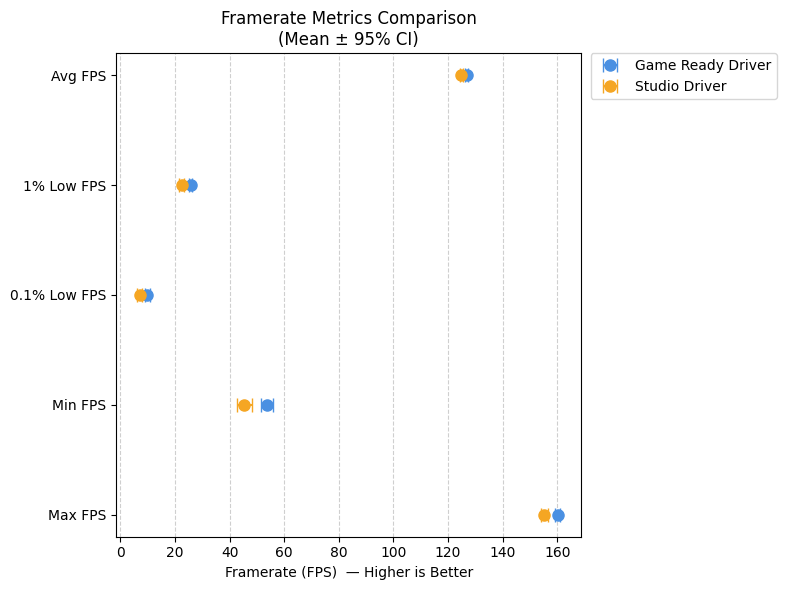

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# -----------------------------
# Load data
# -----------------------------
df_gr = pd.read_csv("/content/game_ready_baseline_stat.csv")
df_st = pd.read_csv("/content/studio_baseline_stat.csv")

df_gr.set_index("Column", inplace=True)
df_st.set_index("Column", inplace=True)

# -----------------------------
# Helper: extract CI half-width
# -----------------------------
def extract_ci(ci_str):
    match = re.search(r'±\s*([0-9]*\.?[0-9]+)', str(ci_str))
    return float(match.group(1)) if match else 0.0

# -----------------------------
# FPS metrics (semantic order)
# -----------------------------
fps_metrics = [
    'Framerate Avg (FPS)',
    'Framerate 1% Low (FPS)',
    'Framerate 0.1% Low (FPS)',
    'Framerate Min (FPS)',
    'Framerate Max (FPS)'
]

labels_fps = [
    'Avg FPS',
    '1% Low FPS',
    '0.1% Low FPS',
    'Min FPS',
    'Max FPS'
]

means_gr = [df_gr.loc[m, 'Mean'] for m in fps_metrics]
cis_gr   = [extract_ci(df_gr.loc[m, 'CI']) for m in fps_metrics]

means_st = [df_st.loc[m, 'Mean'] for m in fps_metrics]
cis_st   = [extract_ci(df_st.loc[m, 'CI']) for m in fps_metrics]

y_pos = range(len(fps_metrics))

# -----------------------------
# Plot: FPS
# -----------------------------
plt.figure(figsize=(8, 6))

plt.errorbar(
    means_gr, y_pos, xerr=cis_gr,
    fmt='o', capsize=5, markersize=8,
    label='Game Ready Driver', color='#4A90E2'
)

plt.errorbar(
    means_st, y_pos, xerr=cis_st,
    fmt='o', capsize=5, markersize=8,
    label='Studio Driver', color='#F5A623'
)

plt.yticks(y_pos, labels_fps)
plt.xlabel('Framerate (FPS)  — Higher is Better')
plt.title('Framerate Metrics Comparison\n(Mean ± 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()


plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

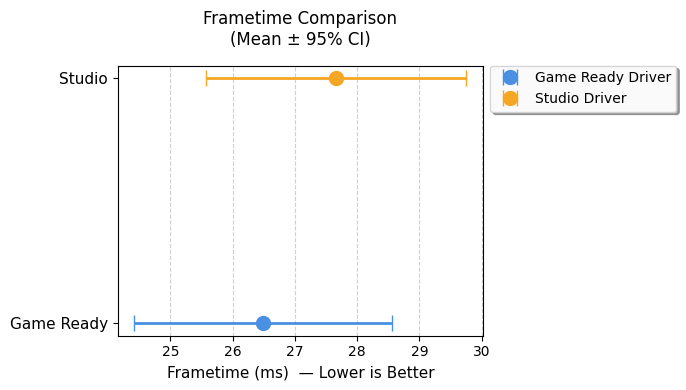

In [6]:
# -----------------------------
# Frametime data
# -----------------------------
frametime_gr = df_gr.loc['Frametime (ms)', 'Mean']
frametime_st = df_st.loc['Frametime (ms)', 'Mean']

ci_gr_ft = extract_ci(df_gr.loc['Frametime (ms)', 'CI'])
ci_st_ft = extract_ci(df_st.loc['Frametime (ms)', 'CI'])

# -----------------------------
# Plot: Frametime
# -----------------------------
plt.figure(figsize=(7, 4))  # ขยายความกว้างเล็กน้อยเพื่อให้มีพื้นที่สำหรับ legend

plt.errorbar(
    frametime_gr, 0, xerr=ci_gr_ft,
    fmt='o', capsize=6, markersize=10,
    label='Game Ready Driver', color='#4A90E2', linewidth=2
)

plt.errorbar(
    frametime_st, 1, xerr=ci_st_ft,
    fmt='o', capsize=6, markersize=10,
    label='Studio Driver', color='#F5A623', linewidth=2
)

plt.yticks([0, 1], ['Game Ready', 'Studio'], fontsize=11)
plt.xlabel('Frametime (ms)  — Lower is Better', fontsize=11)
plt.title('Frametime Comparison\n(Mean ± 95% CI)', fontsize=12, pad=15)

# ✅ ย้าย legend ไปนอกกราฟทางขวาบน — ไม่บังข้อมูลแน่นอน!
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),  # วางนอกกราฟทางขวาบน
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.95,
    facecolor='white',
    edgecolor='lightgray',
    fontsize=10,
    borderaxespad=0.  # ไม่มีระยะห่างจากขอบ
)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()